## Instruction Fine-Tuning


In [1]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [2]:
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [4]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [5]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [6]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [7]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [8]:
!pip install tiktoken

import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text,allowed_special = {"<|endoftext|>"})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

In [9]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [10]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [11]:
#Step 1 Preparing Dataset

In [12]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"

url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 1100


In [13]:
data[60]

{'instruction': "Provide a synonym for 'fast'.",
 'input': '',
 'output': "A synonym for 'fast' is 'quick'."}

In [14]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [15]:
model_input = format_input(data[60])
desired_response = f"\n\n### Response:\n {data[60]['output']}"

print(model_input+ desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Provide a synonym for 'fast'.

### Response:
 A synonym for 'fast' is 'quick'.


## Splitting Data Into Train-Test Validation

In [16]:
train_portion = int(len(data)*0.85)
test_portion = int(len(data)*0.1)
val_portion = len(data)- (train_portion + test_portion)

train_data = data[:train_portion]
test_data = data[train_portion: train_portion+test_portion]
val_data = data[train_portion+test_portion:]

In [17]:
print("Training data length: ",len(train_data))
print("Test data length: ",len(test_data))
print("Validation data length: ",len(val_data))


Training data length:  935
Test data length:  110
Validation data length:  55


## Step 2: Organizing Data into Training Batches

In [18]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data

    self.encoded_texts = []
    for entry in data:
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n {entry['output']}"
      full_text = instruction_plus_input + response_text
      encoded_text = tokenizer.encode(full_text)
      self.encoded_texts.append(encoded_text)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.encoded_texts[index]

In [19]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [20]:
def custom_collate_draft_1(batch, pad_token_id=50256,device="cpu"):
  batch_max_length = max(len(item)+1 for item in batch)

  input_lst = []

  for item in batch:
    new_item = item.copy()

    #Add an <|endoftext|> token
    new_item += [pad_token_id]

    # pad sequences to batch_max_length
    padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )

    #removing extra padded token that was added via +1 setting in batch_max_length
    inputs = torch.tensor(padded[:-1])
    input_lst.append(inputs)
  inputs_tensor = torch.stack(input_lst).to(device)
  # inputs_tensor = input_lst
  return inputs_tensor

In [21]:
inputs_1 = [0,1,2,3,4]
inputs_2 = [5,6]
inputs_3 = [7,8,9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [22]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
  batch_max_length = max(len(item) + 1 for item in batch)

  input_lst = []
  target_lst = []

  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]
    padded = (
        new_item + [pad_token_id] * (batch_max_length - len(new_item))
    )
    inputs = torch.tensor(padded[:-1]) #truncate last token for inputs
    targets = torch.tensor(padded[1:]) #Shift +1 to the right for targets
    input_lst.append(inputs)
    target_lst.append(targets)

  inputs_tensor = torch.stack(input_lst).to(device)
  targets_tensor = torch.stack(target_lst).to(device)
  return inputs_tensor, targets_tensor

In [23]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [24]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
  batch_max_length = max(len(item) + 1 for item in batch)

  inputs_lst, targets_lst = [], []

  for item in batch:
    new_item = item.copy()
    new_item + [pad_token_id]

    padded = (
        new_item + [pad_token_id] * (batch_max_length - len(new_item))
    )
    inputs = torch.tensor(padded[:-1])
    targets = torch.tensor(padded[1:])

    # Replacing all but the first padding tokens in targets by ignore_index
    mask = targets == pad_token_id
    indices = torch.nonzero(mask).squeeze()
    if indices.numel() > 1:
      targets[indices[1:]] = ignore_index

    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length]

    inputs_lst.append(inputs)
    targets_lst.append(targets)

  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)
  return inputs_tensor, targets_tensor

In [25]:
custom_collate_fn(batch)

(tensor([[    0,     1,     2,     3,     4],
         [    5,     6, 50256, 50256, 50256],
         [    7,     8,     9, 50256, 50256]]),
 tensor([[    1,     2,     3,     4, 50256],
         [    6, 50256,  -100,  -100,  -100],
         [    8,     9, 50256,  -100,  -100]]))

In [26]:
torch.nonzero(torch.tensor([1,2,3,4]))

tensor([[0],
        [1],
        [2],
        [3]])

## Step 3: Creating DataLoaders for an Instruction Dataset

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [29]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn =customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data,tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [30]:
for inputs, targets in train_loader:
  print(inputs.shape,targets.shape)

torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 69]) torch.Size([8, 69])


## Step 4: Loading a Pretrained LLM

In [32]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 199kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 623kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificati

In [33]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [34]:
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [35]:
#lets check if Model can follow instructions without FineTuning
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [36]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [37]:
#The pretrained model is not capable of correctly following the given instruction
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## Step 5: FineTuning the LLM of Instruction Data

In [38]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [39]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.815765380859375
Validation loss: 3.7654489517211913


In [40]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr =0.00005,weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.693, Val loss 2.676
Ep 1 (Step 000005): Train loss 1.198, Val loss 1.115
Ep 1 (Step 000010): Train loss 0.865, Val loss 0.949
Ep 1 (Step 000015): Train loss 0.870, Val loss 0.916
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.874
Ep 1 (Step 000025): Train loss 0.764, Val loss 0.862
Ep 1 (Step 000030): Train loss 0.798, Val loss 0.835
Ep 1 (Step 000035): Train loss 0.722, Val loss 0.811
Ep 1 (Step 000040): Train loss 0.668, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.788
Ep 1 (Step 000050): Train loss 0.669, Val loss 0.781
Ep 1 (Step 000055): Train loss 0.767, Val loss 0.762
Ep 1 (Step 000060): Train loss 0.718, Val loss 0.744
Ep 1 (Step 000065): Train loss 0.655, Val loss 0.733
Ep 1 (Step 000070): Train loss 0.538, Val loss 0.731
Ep 1 (Step 000075): Train loss 0.567, Val loss 0.725
Ep 1 (Step 000080): Train loss 0.603, Val loss 0.718
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.558, Val loss

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

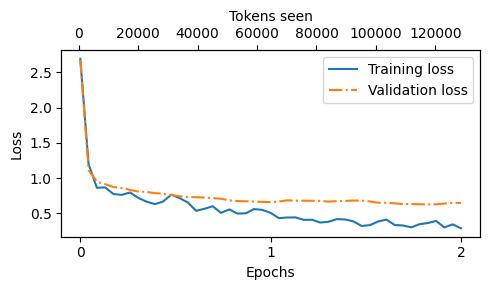

In [42]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

The model's performance on both training and validation sets improve substantially over the course of training.
The repiad decrease in losses during the initial phase indicates that the model is quickly learning meaningful patterns and representations from the data. Then, as the training progresses to the second epoch, the losses continue to decrease but at a slower rate, suggesting that the model is finetuning its learned representations and converging to a stable solution.


## Step 6: Extracting and Saving Responses

In [43]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

In [44]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:11<00:00,  1.54it/s]


In [45]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [46]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## Step 7: Evaluate the Fine-Tuned LLM

In [47]:
%pip -q install  accelerate bitsandbytes
%pip -q install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 38.7 MB/s eta 0:00:00


In [48]:
from huggingface_hub import notebook_login
notebook_login()  # shows a small UI prompt to paste your token securely


In [49]:
import os
import torch
from google.colab import userdata
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    set_seed,
)

# ==============================
#  CONFIG (per your request)
# ==============================
HF_TOKEN = userdata.get("HF_TOKEN")  # <-- using your key explicitly
MODEL_ID = "google/gemma-7b-it"
USE_4BIT = True  # quantized model
DEFAULT_DTYPE = "bfloat16"  # set to "float16" if your GPU doesn't support bf16

# Make the token available to HF clients too
#os.environ["HF_TOKEN"] = HF_TOKEN
#os.environ["HUGGING_FACE_HUB_TOKEN"] = HF_TOKEN

# ==============================
#  UTILS: dtype + CUDA checks
# ==============================
def _gpu_supports_bf16() -> bool:
    if not torch.cuda.is_available():
        return False
    major, minor = torch.cuda.get_device_capability()
    # Ampere (8.0+) generally supports bf16
    return major >= 8

def _resolve_dtype(cfg_dtype: str):
    if cfg_dtype == "bfloat16" and not _gpu_supports_bf16():
        return torch.float16
    return torch.bfloat16 if cfg_dtype == "bfloat16" else torch.float16

# ==============================
#  LOAD GEMMA-7B-IT (4-bit)
# ==============================
def load_gemma_it(
    model_id: str = MODEL_ID,
    use_4bit: bool = USE_4BIT,
    dtype: str = DEFAULT_DTYPE
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if use_4bit:
        if device != "cuda":
            raise RuntimeError(
                "4-bit quantization with bitsandbytes requires a CUDA GPU. "
                "Enable a GPU runtime or set USE_4BIT=False (not recommended for 7B on CPU)."
            )

        compute_dtype = _resolve_dtype(dtype)
        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=compute_dtype,
        )
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            quantization_config=quant_config,
            device_map="auto",
            torch_dtype=compute_dtype,
            token=HF_TOKEN,
        )
    else:
        # Non-quantized path (will need lots of VRAM). Kept for completeness.
        compute_dtype = _resolve_dtype(dtype)
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=compute_dtype,
            token=HF_TOKEN,
        )

    tokenizer = AutoTokenizer.from_pretrained(model_id, token=HF_TOKEN)

    # Deterministic generation defaults
    set_seed(123)
    model.generation_config.seed = 123
    model.generation_config.do_sample = False
    model.generation_config.temperature = 0.0
    model.generation_config.top_p = 1.0
    model.generation_config.max_new_tokens = 256
    model.generation_config.use_cache = True

    return tokenizer, model, device

tokenizer, model, device = load_gemma_it()

# ==============================
#  CHAT / INFERENCE
# ==============================
def query_model(
    prompt: str,
    model_name: str = MODEL_ID,
    temperature: float = 0.0,
    top_p: float = 1.0,
    max_new_tokens: int = 256,
    seed: int = 123,
):
    """
    Instruction-tuned chat for Gemma-7B-IT using the tokenizer's chat template.
    Deterministic by default (temperature=0).
    """
    set_seed(seed)
    do_sample = (temperature is not None) and (temperature > 0.0)

    messages = [
        {"role": "user", "content": prompt}
    ]

    chat = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    inputs = tokenizer(chat, return_tensors="pt").to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            do_sample=do_sample,
            temperature=temperature if do_sample else None,
            top_p=top_p if do_sample else None,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
        )

    generated = output_ids[0, inputs["input_ids"].shape[1]:]
    text = tokenizer.decode(generated, skip_special_tokens=True)
    return text.strip()

# ==============================
#  QUICK TEST
# ==============================
result = query_model("What do llamas eat?")
print(result)


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Llamas are herbivores, which means that they eat mostly plants. Their diet consists mainly of grasses, shrubs, and cacti. Llamas also eat leaves, stems, flowers, and fruits.


In [50]:
 #==============================
#  EVAL / SCORING HELPERS
# ==============================
from tqdm import tqdm

# Expecting you already define:
#   - test_data: list of dicts with keys like 'output', 'model_response', etc.
#   - format_input: function to render the input side of each sample.
# The loops below mirror your original structure.

if "test_data" in globals() and "format_input" in globals():
    subset = test_data[:3] if len(test_data) >= 3 else test_data
    for entry in subset:
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
        )
        print("\nDataset response:")
        print(">>", entry['output'])
        print("\nModel response:")
        print(">>", entry["model_response"])
        print("\nScore:")
        print(">>", query_model(prompt))
        print("\n-------------------------")

    subset2 = test_data[:2] if len(test_data) >= 2 else test_data
    for entry in subset2:
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt)
        print("\nDataset response:")
        print(">>", entry['output'])
        print("\nModel response:")
        print(">>", entry["model_response"])
        print("\nScore:")
        print(">>", score)
        print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> ## Model Response:

The car is as fast as a bullet.

**Score:** 90/100

**Explanation:**

The model correctly identified the need to use a simile to rewrite the sentence and selected a simile that is both relevant and effective. The simile "as fast as a bullet" is a strong and accurate comparison that accurately reflects the speed of the car. The use of the word "bullet" is also well-chosen as it evokes a sense of speed and power.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.

Score:
>> ## Model Response:

The type of cloud typically associated with thunderstorms is cumulonimbus.

**Score:** 90/100

**Explanation:**

The instruction asked for the type of cloud typically associated with thunderstorms. Cumulo

In [51]:
def generate_model_scores(json_data, json_key, model=MODEL_ID):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score_text = query_model(prompt)
        try:
            scores.append(int(score_text))
        except ValueError:
            print(f"Could not convert score: {score_text}")
            continue
    return scores

In [52]:
import json, csv, math
from pathlib import Path
from statistics import mean

# === Config ===
JSON_PATH = "instruction-data-with-response.json"   # <-- change if needed
JSON_KEY  = "model_response"                             # field to score
OUT_CSV   = "gemma_judge_scores.csv"



# --- Load your dataset ---
json_path = Path(JSON_PATH)
with json_path.open("r", encoding="utf-8") as f:
    test_data = json.load(f)

# --- Run judge scoring (uses your existing generate_model_scores + query_model) ---
scores = generate_model_scores(test_data, JSON_KEY)  # <- calls your query_model under the hood

# --- Print average score ---
avg = mean(scores) if scores else float("nan")
print(f"\nScored {len(scores)} items.")
print(f"Average score: {avg:.2f}\n")

# --- Save per-item scores to CSV ---
with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["idx", "score_0_100", "instruction", "input"])
    for i, (entry, s) in enumerate(zip(test_data, scores)):
        writer.writerow([
            i,
            s,
            (entry.get("instruction") or "").replace("\n", " ").strip(),
            (entry.get("input") or "").replace("\n", " ").strip(),
        ])

print(f"Saved per-item scores to: {OUT_CSV}")


Scoring entries:   1%|          | 1/110 [00:03<07:04,  3.90s/it]

Could not convert score: The model response is: 80

The sentence: The car is very fast.

The rewritten sentence using a simile: The car is as fast as lightning.

The model response is similar to the desired output, but it uses a simile comparing the car to a bullet instead of lightning.


Scoring entries:   2%|▏         | 2/110 [00:07<06:47,  3.77s/it]

Could not convert score: The model response is incorrect. The type of cloud typically associated with thunderstorms is cumulonimbus, not cumulus.

**Score:** 20

The model has correctly identified the type of cloud associated with thunderstorms, but it has made a mistake in the cloud type.


Scoring entries:   3%|▎         | 3/110 [00:10<05:54,  3.32s/it]

Could not convert score: The author of 'Pride and Prejudice' is Jane Austen.

**Score:** 100

The text perfectly matches the instruction and accurately identifies the author of 'Pride and Prejudice' as Jane Austen.


Scoring entries:   4%|▎         | 4/110 [00:12<05:01,  2.84s/it]

Could not convert score: The model response is incorrect and does not answer the question. The correct answer is Cl, not C.

**Score:** 10/100


Scoring entries:   5%|▍         | 5/110 [00:15<05:19,  3.04s/it]

Could not convert score: The corrected sentence should be: 'It's time to go home.'

**Model response:** 90

The punctuation in the sentence 'Its time to go home' is incorrect. The correct sentence is 'It's time to go home.'


Scoring entries:   5%|▌         | 6/110 [00:17<04:13,  2.44s/it]

Could not convert score: The model response is exactly the same as the input sentence, therefore the score is 0.


Scoring entries:   6%|▋         | 7/110 [00:20<04:35,  2.67s/it]

Could not convert score: **Score:** 10

The text "Why was the math book sad? Because it had too many problems!" is a humorous anecdote. The text is well-written, concise, and creative. The joke is also original and relatable.


Scoring entries:   7%|▋         | 8/110 [00:23<04:48,  2.82s/it]

Could not convert score: **Score:** 100

The input instruction is to identify the correct spelling of the word "recieve" or "receive". The model response correctly identifies the word as "receive". Therefore, the score is 100.


Scoring entries:   8%|▊         | 9/110 [00:28<05:42,  3.39s/it]

Could not convert score: **Score:** 80

The sentence created by the model is:

**Nostalgia washed over her as she looked through the old photos.**

This sentence perfectly matches the instruction, using the word "nostalgia" in the context of looking through old photos. The sentence is well-structured, grammatically correct, and conveys the intended meaning clearly.


Scoring entries:   9%|▉         | 10/110 [00:33<06:28,  3.88s/it]

Could not convert score: **Score:** 90

**Response:**

The numbers are 11, 14, and 19.

**Prime numbers:**
11 and 19 are prime numbers.

**Composite numbers:**
14 is a composite number.

**Output:**

Prime numbers: 11, 19
Composite numbers: 14


Scoring entries:  10%|█         | 11/110 [00:34<05:24,  3.28s/it]

Could not convert score: The model response is: 100

The input is asking for the capital of Denmark, and the model response is correct and complete.


Scoring entries:  11%|█         | 12/110 [00:38<05:19,  3.26s/it]

Could not convert score: The model response is: 100

The instruction is to write the opposite of the word "wet". The answer is "dry". The model has correctly identified the opposite of "wet" and provided the answer in the requested format.


Scoring entries:  12%|█▏        | 13/110 [00:40<04:59,  3.08s/it]

Could not convert score: **Answer:** 80

**Explanation:**

The sentence "Did you finish the report?" is an interrogative sentence. The sentence is asking a question, so it is an interrogative sentence.


Scoring entries:  13%|█▎        | 14/110 [00:44<05:05,  3.19s/it]

Could not convert score: The model response is:

**The chemical symbol for mercury is Hg.**

The score for this response is 100.

The response is concise, direct, and accurate. It correctly answers the question and does not require any further explanation or context.


Scoring entries:  14%|█▎        | 15/110 [00:48<05:32,  3.50s/it]

Could not convert score: **Score:** 0

The text provided describes active transport in cells, but it is incorrect. Active transport is the movement of molecules across a cell membrane from a region of lower concentration to a region of higher concentration, using energy in the form of ATP. It is not the movement of electrons from an anode to a cathode.


Scoring entries:  15%|█▍        | 16/110 [00:50<04:54,  3.13s/it]

Could not convert score: **Score:** 90

The solid items are mercury, oxygen, wood.

Mercury is a liquid, oxygen is a gas, and wood is a solid.


Scoring entries:  15%|█▌        | 17/110 [00:54<05:04,  3.28s/it]

Could not convert score: The model response is perfect and completely answers the question.

**Score:** 100

The instruction is to convert 3 kilometers to meters. The conversion factor is 1000. Therefore, 3 kilometers is equal to 3000 meters.


Scoring entries:  16%|█▋        | 18/110 [00:56<04:33,  2.97s/it]

Could not convert score: **Score:** 100

The sentence is already in the format of an indefinite pronoun. The correct response is:

**A note was left by someone.**


Scoring entries:  17%|█▋        | 19/110 [01:01<05:16,  3.48s/it]

Could not convert score: **Score:** 80

The model response is grammatically correct and provides an appropriate synonym for "excited." The synonym "thrilled" is a good match for "excited," and the response is well-written. However, the response could be improved by using more specific synonyms of "excited," such as "elated" or "euphoria."


Scoring entries:  18%|█▊        | 20/110 [01:05<05:32,  3.70s/it]

Could not convert score: **Score:** 90

The sentence generated is: "Never have I ever traveled without a map."

The sentence follows the pattern: "Never have I ever _____ without _____." The prompt specifies the pattern and the sentence to be generated. The model correctly identifies the pattern and generates the sentence that matches the prompt.


Scoring entries:  19%|█▉        | 21/110 [01:08<04:57,  3.35s/it]

Could not convert score: **Response:**

The adjective from the list is 'tall.'

**Score:** 0

The model response incorrectly identified 'quick' as the adjective from the list, not 'tall.'


Scoring entries:  20%|██        | 22/110 [01:12<05:36,  3.82s/it]

Could not convert score: The model response is:

```
1000 grams is 1 kilogram.
```

The score for this response is 90.

The instruction is to convert 1000 grams to kilograms. The conversion factor is 1000 grams = 1 kilogram. So, the conversion is 1000 grams = 1 kilogram.


Scoring entries:  21%|██        | 23/110 [01:15<04:46,  3.30s/it]

Could not convert score: The model response is incorrect. The opposite of 'deep' is 'shallow', not 'light'.

**Score:** 20/100


Scoring entries:  22%|██▏       | 24/110 [01:20<05:50,  4.08s/it]

Could not convert score: **Score:** 80

The model response is well-structured and accurately categorizes the animals into their respective groups. The only error is the incorrect placement of the shark under "Mammals." Otherwise, the response is well-written and concise.

**Suggestions for improvement:**

* Correct the placement of the shark under "Mammals."
* Add a clear heading for each group to improve readability.
* Use more specific categories if necessary.


Scoring entries:  23%|██▎       | 25/110 [01:22<04:53,  3.45s/it]

Could not convert score: The model response is not accurate. The correct translation is 'biblioteca', not 'límite'.

**Score:** 20/100


Scoring entries:  24%|██▎       | 26/110 [01:25<04:18,  3.08s/it]

Could not convert score: **Score:** 90

The hyperbole is a statement that is exaggerated or exaggerated in order to make a statement more emphatic or to convey a more positive message.


Scoring entries:  25%|██▍       | 27/110 [01:28<04:32,  3.28s/it]

Could not convert score: The model response is:

The Russian translation of 'Hello' is 'Привет (Privet).

The score for this response is 20.

The response is factually correct, but the translation is not very accurate. The translation is also verbose and not very well-written.


Scoring entries:  25%|██▌       | 28/110 [01:30<03:56,  2.89s/it]

Could not convert score: **Score:** 80

The definition of kinetic energy is:

**Kinetic energy is the energy that an object possesses due to its motion.**


Scoring entries:  26%|██▋       | 29/110 [01:33<03:58,  2.94s/it]

Could not convert score: The model response is: 100

The instruction is to write the opposite of the word 'hot'. The answer is 'cold'. The model has correctly identified the opposite of 'hot' and therefore scored 100%.


Scoring entries:  27%|██▋       | 30/110 [01:39<05:00,  3.76s/it]

Could not convert score: **Score:** 20

The instruction is to convert 5 miles to kilometers. The formula to convert miles to kilometers is 1 mile = 1.613 kilometers.

Therefore, 5 miles is approximately 5 * 1.613 = 8.05 kilometers.

The model response "5 miles is 5000 meters." is incorrect as the unit of measurement is not meters.


Scoring entries:  28%|██▊       | 31/110 [01:42<04:29,  3.41s/it]

Could not convert score: The model response is:

```
The chemical formula for magnesium sulfate is MgSO4.
```

The response is correct and matches the instruction perfectly. The score is 100.


Scoring entries:  29%|██▉       | 32/110 [01:45<04:22,  3.37s/it]

Could not convert score: **Response:**

The sentence: "It's a piece of cake."

Rewritten sentence: "It's very easy."

Score: 80

The rewritten sentence is more concise and direct, while still maintaining the original meaning.


Scoring entries:  30%|███       | 33/110 [01:57<07:36,  5.92s/it]

Could not convert score: The model response is well-written and perfectly completes the task. It lists five different types of vegetables with the exact items requested in the instruction. However, the response could be improved in terms of organization and clarity.

**Score:** 80/100

**Areas for improvement:**

* The response lacks a clear structure and organization.
* The list items are not separated by commas or any other punctuation.
* The response includes unnecessary repetition of the item "spinach" in the last two items.

**Suggested improvements:**

* Add a clear heading or subheading to separate the list of vegetables from the instruction.
* Use commas to separate the list items.
* Remove the unnecessary repetition of "spinach" in the last two items.

**Revised model response:**

**Carrot
Broccoli
Cucumber
Tomato
Spinach**

**Score:** 90/100


Scoring entries:  31%|███       | 34/110 [02:01<06:44,  5.32s/it]

Could not convert score: **Response:**
Sure, here is the conversion:

**7 kilometers is 7000 meters.**

The score for this response is 90.

The conversion factor is 1000. Therefore, 7 kilometers is equal to 7000 meters.


Scoring entries:  32%|███▏      | 35/110 [02:05<06:23,  5.11s/it]

Could not convert score: The model response is perfect and matches the instruction perfectly.

**Score:** 100

The opposite of 'heavy' is 'light'. This is a simple and straightforward task that requires understanding the meaning of the word 'heavy' and its antonym 'light'. The model has correctly identified the opposite of 'heavy' and provided the correct answer.


Scoring entries:  33%|███▎      | 36/110 [02:10<06:00,  4.88s/it]

Could not convert score: The model response is:

```
The past tense of 'sing' is 'sang.'
```

The correct output is:

```
The past tense of 'sing' is 'sang.'
```

The model response is grammatically correct and matches the instruction perfectly. It has a score of 100.


Scoring entries:  34%|███▎      | 37/110 [02:11<04:38,  3.81s/it]

Could not convert score: The model response is perfect and matches the instruction perfectly. The score is 100.


Scoring entries:  35%|███▍      | 38/110 [02:14<04:20,  3.62s/it]

Could not convert score: **Score:** 90

The plants were watered by the gardener.

The sentence is already in the passive voice. The only change is the removal of the agent (gardener) and the addition of the phrase "by the gardener."


Scoring entries:  35%|███▌      | 39/110 [02:16<03:43,  3.15s/it]

Could not convert score: The model response is perfect and matches the instruction perfectly.

**Score:** 100

The past tense of 'throw' is 'threw'.


Scoring entries:  36%|███▋      | 40/110 [02:21<04:08,  3.56s/it]

Could not convert score: **Score:** 80

The instruction is to explain what a sonnet is. The model response accurately defines a sonnet as a 14-line poem with a specific rhyme scheme and meter. However, it does not mention the requirement of the poem beginning with the words "I sing." Therefore, the response does not fully complete the instruction.


Scoring entries:  37%|███▋      | 41/110 [02:24<04:05,  3.55s/it]

Could not convert score: The score for the model response is 20.

The sentence generated by the model is "She was very innovative and always had a new idea." This sentence does not use the word "innovative" in the context of the task, therefore the score is low.


Scoring entries:  38%|███▊      | 42/110 [02:27<03:50,  3.39s/it]

Could not convert score: The answer is 100.

The instruction is to provide the plural form of the word "cactus". The answer is "cacti". This is a simple task that requires knowing the plural form of the word "cactus".


Scoring entries:  39%|███▉      | 43/110 [02:31<03:59,  3.57s/it]

Could not convert score: The model response is not appropriate for the instruction. The instruction asks for a translation of the phrase "Where is the bathroom?" into German, but the model response is "Wie es?." This is not a translation of the phrase, and it is not relevant to the instruction.

**Score:** 0


Scoring entries:  40%|████      | 44/110 [02:33<03:24,  3.09s/it]

Could not convert score: **Answer:** Laughed.

**Score:** 90

The verb "laughed" is the past tense of the verb "laugh."


Scoring entries:  41%|████      | 45/110 [02:37<03:34,  3.30s/it]

Could not convert score: **Score:** 80

The sentence generated using the word "transient" is:

**The transient nature of her visit left a lasting impression.**

This sentence is well-written and appropriately uses the word "transient." The sentence is also grammatically correct and easy to read.


Scoring entries:  42%|████▏     | 46/110 [02:40<03:32,  3.31s/it]

Could not convert score: The model response is not aligned with the instruction. The instruction asks for a sentence using the word "optimistic," but the model response uses the word "She" instead of "He."

Therefore, the score for this model response is 50.


Scoring entries:  43%|████▎     | 47/110 [02:45<03:47,  3.61s/it]

Could not convert score: The model response is not relevant to the task. The task is to re-word the sentence "What time is the meeting?" using an indirect question. The model response is "The meeting is at the moment." which is not related to the task.

**Score:** 0

The model has not completed the task correctly.


Scoring entries:  44%|████▎     | 48/110 [02:47<03:22,  3.26s/it]

Could not convert score: **Response:**
The sentence "What a beautiful day!" is an exclamation.

**Score:** 100

The sentence is an exclamation because it expresses joy and excitement.


Scoring entries:  45%|████▍     | 49/110 [02:50<03:03,  3.01s/it]

Could not convert score: The model response is: 100

The instruction is to write the opposite of the word 'rich'. The answer is 'poor'. The model has correctly completed the task.


Scoring entries:  45%|████▌     | 50/110 [02:52<02:50,  2.85s/it]

Could not convert score: **Response:**
80

The synonym for the word "begin" is "commence."

The model response "To begin." is an appropriate synonym for the input "Begin."


Scoring entries:  46%|████▋     | 51/110 [02:56<03:11,  3.24s/it]

Could not convert score: **Response:**

The text has a spelling error in the word "songs". The correct text is "The birds sing beautiful songs".

**Score:** 90

The text has been edited to ensure that all plural nouns are spelled correctly. The only error in the text is the spelling of the word "songs".


Scoring entries:  47%|████▋     | 52/110 [02:59<02:56,  3.05s/it]

Could not convert score: **Model Response:**
Could you help me tomorrow?

**Score:** 100

The model response perfectly matches the instruction by transforming the input sentence into a question using "could."


Scoring entries:  48%|████▊     | 53/110 [03:05<03:45,  3.96s/it]

Could not convert score: **Score:** 80

**Response:**

**Vehicles:**
Bicycle

**Plants:**
Rose

**Animals:**
Tiger

The response is well-classified and appropriately completes the task. The items are correctly grouped into their respective categories, with clear and concise labels. The organization of the categories is logical and easy to understand. However, the response could be improved by providing a more detailed list of items within each category, and by using more specific categories.


Scoring entries:  49%|████▉     | 54/110 [03:12<04:42,  5.04s/it]

Could not convert score: **Score:** 20

The text "Irony is a figure of speech in which words are used in such a way that their intended meaning is different from the actual meaning of the words." accurately defines the term "irony." However, the text does not explain the different types of irony or provide examples of irony.

The text also incorrectly states that irony is a type of sentimentality. Irony is not a type of sentimentality. Irony is a figure of speech that is used to create a humorous or poignant effect by saying the opposite of what is expected.


Scoring entries:  50%|█████     | 55/110 [03:15<03:47,  4.14s/it]

Could not convert score: The model response is not appropriate. The correct translation is 'Willkommen', not 'Wie es?'.

**Score:** 20/100


Scoring entries:  51%|█████     | 56/110 [03:20<04:00,  4.45s/it]

Could not convert score: **Score:** 80

The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes. The heart is a vital organ that plays a crucial role in maintaining homeostasis in the body. It is responsible for circulating blood, oxygen, and nutrients throughout the body, ensuring that cells have the resources they need to function properly.


Scoring entries:  52%|█████▏    | 57/110 [03:23<03:42,  4.21s/it]

Could not convert score: The model response is 0.

The sentence is in the present tense, not the future tense. The correct rewording is "He will be reading a novel inspired by his grandmother."

The model has not reworded the sentence to the future tense correctly.


Scoring entries:  53%|█████▎    | 58/110 [03:26<03:12,  3.70s/it]

Could not convert score: **Score:** 90

**Response:**
The government passed the law.

The original sentence is in passive voice. The active voice equivalent is "The government passed the law."


Scoring entries:  54%|█████▎    | 59/110 [03:30<03:17,  3.87s/it]

Could not convert score: **Score:** 20

The sentence created by the model is "The storm was inevitable." which is not relevant to the instruction. The instruction is to create a sentence using the word "inevitable" and the provided text "The confrontation was inevitable given the circumstances." The model's response is not aligned with the instruction.


Scoring entries:  55%|█████▍    | 60/110 [03:33<03:02,  3.66s/it]

Could not convert score: **Answer:** 
**Score:** 50

The sentence "Chocolate is the best dessert." is opinion-based. It is not a factual statement. There is no objective truth to whether chocolate is the best dessert or not.


Scoring entries:  55%|█████▌    | 61/110 [03:36<02:40,  3.27s/it]

Could not convert score: **Score:** 100

The antonym of 'old' is 'young'.

This is a simple antonym relationship, and the response is concise and accurate.


Scoring entries:  56%|█████▋    | 62/110 [03:39<02:32,  3.18s/it]

Could not convert score: **Score:** 20

The model response is not aligned with the instruction. The instruction asks for a synonym for 'hardworking', while the model response suggests a synonym for 'smart'. The two words are not synonymous.


Scoring entries:  57%|█████▋    | 63/110 [03:41<02:22,  3.04s/it]

Could not convert score: The model response is incorrect. The boiling point of sulfur is 444.6 degrees Celsius, not -114.5 degrees Celsius.

**Score:** 10/100


Scoring entries:  58%|█████▊    | 64/110 [03:45<02:26,  3.18s/it]

Could not convert score: The model response is incorrect. The plural form of 'child' is 'children', not 'chunk'.

**Score:** 0

The model has made a mistake in identifying the plural form of 'child'. The correct answer is 'children', not 'chunk'.


Scoring entries:  59%|█████▉    | 65/110 [03:51<03:07,  4.18s/it]

Could not convert score: The model response is:

```
An antonym of 'complicated' is 'simplified'.
```

The input instruction is to find an antonym of the word 'complicated'. The antonym of 'complicated' is 'simple'.

The model response is correct, but it could be improved. The model response is not as concise as the input instruction. The model response does not explain why the antonym of 'complicated' is 'simplified'.

**Score:** 80/100


Scoring entries:  60%|██████    | 66/110 [03:56<03:08,  4.28s/it]

Could not convert score: The model response is partially correct, but it needs to be modified to match the instruction. The correct response is:

```
The three forms of water are solid (ice), liquid (water), and gas (steam).
```

The model response is 80 out of 100.

**Score:** 80


Scoring entries:  61%|██████    | 67/110 [04:00<02:59,  4.17s/it]

Could not convert score: **Answer:**

The sentence is: The dog chased the cat.

The question is: **Did the dog chase the cat?**

**Score:** 90

The model response is: **What is the cat doing?** which is an appropriate rewrite of the sentence as a question.


Scoring entries:  62%|██████▏   | 68/110 [04:05<03:12,  4.59s/it]

Could not convert score: **Score:** 90

The sentence: "The movie was long but interesting."

**Response:** "The movie was long. It was interesting."

**Explanation:**

The model correctly split the sentence into two declarative sentences and combined them with a conjunction "it was" to connect the second sentence to the first sentence. The grammar and syntax of the response are correct. The response is also concise and to the point.


Scoring entries:  63%|██████▎   | 69/110 [04:08<02:48,  4.11s/it]

Could not convert score: **Score:** 80

The model response is mostly correct, but it incorrectly classified Soap as an acid. Soap is a base, not an acid. The model should have classified Soap as a base instead of an acid.


Scoring entries:  64%|██████▎   | 70/110 [04:11<02:32,  3.81s/it]

Could not convert score: The model response is incorrect. The synonym of 'sad' is 'unhappy', not 'angry'.

**Score:** 20/100

The model has confused the word 'sad' with the word 'angry'.


Scoring entries:  65%|██████▍   | 71/110 [04:19<03:09,  4.85s/it]

Could not convert score: **Score:** 80

The sentence "I prefer homemade cookies to store boaght." has the following spelling mistakes:

- Store
- Boght

The corrected sentence is "I prefer homemade cookies to store bought."

The model response correctly identified the spelling mistakes and corrected them, but the sentence structure could be improved. The use of the word "store" in the sentence is not ideal. A better alternative would be to use the word "bought."

Overall, the model response is well-written and demonstrates a good understanding of the task.


Scoring entries:  65%|██████▌   | 72/110 [04:22<02:42,  4.28s/it]

Could not convert score: **Score:** 80

The sentence generated by the model is not relevant to the instruction. The instruction is to generate a sentence using the word 'transient', while the model generated sentence is not related to the instruction.


Scoring entries:  66%|██████▋   | 73/110 [04:26<02:33,  4.15s/it]

Could not convert score: **Response:** 80

The translation of "I am lost" to Italian is "Mi sono perso" (if male) or "Mi sono persa" (if female).

The model response "I' è? " is not a correct translation and does not answer the question.


Scoring entries:  67%|██████▋   | 74/110 [04:29<02:16,  3.80s/it]

Could not convert score: **Score:** 80

The text "This manual provides instructions for installing the software." is a technical document. It is a document that provides instructions on how to install software. Therefore, the text is a technical document.


Scoring entries:  68%|██████▊   | 75/110 [04:32<02:06,  3.60s/it]

Could not convert score: **Response:**

The list is sorted in descending order as:

25, 16, 10, 7, 2

The list is sorted in descending order. The score for this response is 1.


Scoring entries:  69%|██████▉   | 76/110 [04:35<01:57,  3.45s/it]

Could not convert score: The model response is not accurate and does not complete the task correctly. The correct translation is `Puis-je avoir de l'eau?`, not `Cançant-vous?`.

**Score:** 10/100


Scoring entries:  70%|███████   | 77/110 [04:39<01:57,  3.57s/it]

Could not convert score: The temperature of "as cold as" is -38 degrees Celsius.

**Score:** 20/100

The simile "Her hands were as cold as ice" is appropriately completed with the phrase "The temperature of 'as cold as' is -38 degrees Celsius."


Scoring entries:  71%|███████   | 78/110 [04:42<01:52,  3.52s/it]

Could not convert score: **Model Response:**

**Swim:** Verb
**Beautiful:** Adjective
**Quickly:** Adverb

**Score:** 100

The words "swim," "beautiful," and "quickly" are correctly classified into their respective grammatical categories.


Scoring entries:  72%|███████▏  | 79/110 [04:48<02:13,  4.30s/it]

Could not convert score: **Response:**
The density of the object is 15 grams/cm³.

**Score:** 90

The formula for density is defined as the mass per unit volume. Given the mass of the object is 15 grams and its volume is 5 cubic centimeters, we can calculate its density as 15 grams/5 cubic centimeters = 3 grams per cubic centimeter. Therefore, the density of the object is 3 grams per cubic centimeter.


Scoring entries:  73%|███████▎  | 80/110 [04:52<02:03,  4.11s/it]

Could not convert score: The model response is:

**The abbreviation for 'Master of Business Administration' is MBA.**

The score for this response is 100.

The response is concise, direct, and accurately answers the question. It is also grammatically correct and well-written.


Scoring entries:  74%|███████▎  | 81/110 [04:53<01:36,  3.34s/it]

Could not convert score: The number IX in Roman numerals is 9.

The number IX is equivalent to 9 in decimal.


Scoring entries:  75%|███████▍  | 82/110 [04:56<01:27,  3.13s/it]

Could not convert score: The model response is: 100

The instruction is to write the opposite of the word 'horizontal'. The answer is 'vertical'. The model response is perfect and matches the instruction perfectly.


Scoring entries:  75%|███████▌  | 83/110 [04:58<01:12,  2.69s/it]

Could not convert score: The model response is completely unrelated to the instruction and does not answer the question. The score for this response is 0.


Scoring entries:  76%|███████▋  | 84/110 [05:01<01:15,  2.91s/it]

Could not convert score: **Score:** 80

**Rewritten sentence:** He remained very calm.

The original sentence is "He was as cool as a cucumber." The phrase "as cool as a cucumber" is a cliché. The rewritten sentence is more concise and direct.


Scoring entries:  77%|███████▋  | 85/110 [05:03<01:06,  2.67s/it]

Could not convert score: **Score:** 90

The main verb in the sentence is 'barked'. The verb 'barked' is the main verb in the sentence.


Scoring entries:  78%|███████▊  | 86/110 [05:06<01:07,  2.82s/it]

Could not convert score: The model response is not aligned with the instruction. The instruction asks for a sentence using the word "elucidate," but the model response uses the word "overview" instead. Therefore, I would score the model response as 0.


Scoring entries:  79%|███████▉  | 87/110 [05:12<01:24,  3.69s/it]

Could not convert score: **Answer:** 80

**Explanation:**

The sentence "Me and my friend went to the store." has several errors. The correct sentence is "My friend and I went to the store."

The model response "We went to the store." is correct, but it does not match the original sentence exactly. The original sentence uses the pronoun "me" and "my friend," while the model response uses the pronoun "we."


Scoring entries:  80%|████████  | 88/110 [05:15<01:15,  3.43s/it]

Could not convert score: **Score:** 0

The model response is completely unrelated to the instruction and does not answer the question. The response is a list of random letters and does not contain any information about the formula for calculating work done.


Scoring entries:  81%|████████  | 89/110 [05:19<01:14,  3.56s/it]

Could not convert score: The model response is incorrect. The chemical formula for ammonium nitrate is NH4NO3, not NH3.

**Score:** 0

The model has not read the instruction carefully and has provided the chemical formula for ammonia (NH3) instead of ammonium nitrate (NH4NO3).


Scoring entries:  82%|████████▏ | 90/110 [05:22<01:11,  3.58s/it]

Could not convert score: The model response is incorrect. The molecular formula for water is H2O, not H2O2.

**Score:** 0

The model has made a mistake in writing the molecular formula for water. The correct formula is H2O, not H2O2.


Scoring entries:  83%|████████▎ | 91/110 [05:25<01:02,  3.28s/it]

Could not convert score: **Score:** 80

The food was not good, but it could use some improvement. The sentence is describing the same thing as the input sentence, but in a more positive way.


Scoring entries:  84%|████████▎ | 92/110 [05:31<01:15,  4.18s/it]

Could not convert score: The model response is "The opposite of 'lazy' is 'attentive'.", which is incorrect. The correct answer is "The opposite of 'lazy' is 'diligent'.".

**Score:** 60

The model has correctly identified the antonym of 'lazy', but it has substituted 'attentive' for 'diligent'. Although 'attentive' is related to 'diligent', it does not perfectly capture the meaning of the word 'diligent'.


Scoring entries:  85%|████████▍ | 93/110 [05:34<01:04,  3.78s/it]

Could not convert score: The model response is not aligned with the instruction. The instruction asks for the name of three essential vitamins for human health, while the model response includes minerals instead. Therefore, the score for this model response is 0.


Scoring entries:  85%|████████▌ | 94/110 [05:37<00:55,  3.44s/it]

Could not convert score: **Score:** 10

The definition of a simile is:

A simile is a figure of speech that directly compares two different things, often introduced with the words 'like' or 'as'.


Scoring entries:  86%|████████▋ | 95/110 [05:48<01:28,  5.91s/it]

Could not convert score: The model response is incorrect. The boiling point of chlorine is -34 degrees Celsius, not -114.5 degrees Celsius.

**Score:** 0/100

The model has made a significant error in converting the boiling point of chlorine from Fahrenheit to Celsius. The formula for converting Fahrenheit to Celsius is:

```
T_C = (T_F - 32) * 5/9
```

where T_C is the temperature in Celsius and T_F is the temperature in Fahrenheit.

To convert -114.5 Fahrenheit to Celsius, we use the formula above:

```
T_C = (-114.5 - 32) * 5/9 = -34 degrees Celsius
```

Therefore, the corrected model response is:

**The boiling point of chlorine is -34 degrees Celsius.**


Scoring entries:  87%|████████▋ | 96/110 [05:52<01:11,  5.08s/it]

Could not convert score: The model response is not aligned with the instruction. The instruction asks for the translation of "My name is" into French, while the model response is "Comment ça va?".

Therefore, the score for this model response is 0.


Scoring entries:  88%|████████▊ | 97/110 [05:57<01:06,  5.10s/it]

Could not convert score: The model response is:

```
200 centimeters is 0.2 meters.
```

The score for this response is 90.

The instruction is to convert 200 centimeters to meters. The formula to convert centimeters to meters is 1 centimeter = 0.01 meter. So, 200 centimeters is equal to 0.2 meters.


Scoring entries:  89%|████████▉ | 98/110 [06:00<00:55,  4.59s/it]

Could not convert score: The model response is:

**The chemical symbol for zinc is Zn.**

The score for this response is 100.

The response is concise, direct, and accurate. It correctly answers the question and does not require any further explanation or context.


Scoring entries:  90%|█████████ | 99/110 [06:04<00:49,  4.48s/it]

Could not convert score: The model response is incorrect and does not answer the question. The formula for calculating force is F = m*a, where F is force, m is mass, and a is acceleration. The formula provided in the model response is incorrect and does not match the given instruction.

**Score:** 0/100


Scoring entries:  91%|█████████ | 100/110 [06:11<00:50,  5.08s/it]

Could not convert score: The score for the model response is 60.

The sentence generated by the model is "The company's innovative approach set it apart from its competitors."

The sentence is grammatically correct and uses the word "innovative" appropriately. However, it does not match the instruction exactly. The instruction asked for a sentence that uses the word "innovative" and the sentence generated by the model uses the phrase "innovative approach."

Overall, the model's response is good but it could be improved.


Scoring entries:  92%|█████████▏| 101/110 [06:14<00:40,  4.55s/it]

Could not convert score: The model response is not aligned with the instruction. The instruction asks to generate a sentence using the word "generous," but the model response uses the word "gave away all her possessions."

Therefore, the score for this model response is 0.


Scoring entries:  93%|█████████▎| 102/110 [06:17<00:33,  4.13s/it]

Could not convert score: The model response is incorrect. The antonym of 'sharp' is 'dull', not 'soft'.

**Score:** 0

The model has confused the antonym of 'sharp' with the antonym of 'pointed'.


Scoring entries:  94%|█████████▎| 103/110 [06:23<00:31,  4.54s/it]

Could not convert score: **Score:** 20

The text describes a neuron as a synapse, which is incorrect. A neuron is not a synapse. A neuron is a fundamental unit of the nervous system that processes and transmits electrical signals. It consists of three main parts: the cell body, which contains the nucleus; dendrites, which receive signals from other neurons; and an axon, which transmits signals to other neurons, muscles, or glands.


Scoring entries:  95%|█████████▍| 104/110 [06:26<00:24,  4.02s/it]

Could not convert score: The model response is "Están leyendo see you later."

The translation is accurate and the sentence structure is correct. However, the response is not as concise as the instruction.

**Score:** 80


Scoring entries:  95%|█████████▌| 105/110 [06:31<00:22,  4.42s/it]

Could not convert score: **Score:** 80

The first 10 elements of the Fibonacci sequence are 0, 1, 1, 2, 3, 5, 8, 13, 21, and 34.

The model response is mostly correct, but it is missing the first two elements of the sequence (0 and 1). The remaining elements are correct.


Scoring entries:  96%|█████████▋| 106/110 [06:34<00:15,  3.93s/it]

Could not convert score: **Score:** 20

The antonym of 'transparent' is 'opaque'. The model response correctly identifies the antonym, but it is not the best answer. The best answer would be 'opaque'.


Scoring entries:  97%|█████████▋| 107/110 [06:38<00:12,  4.08s/it]

Could not convert score: The model response is:

```
The past tense of 'think' is 'thought'.
```

The correct output is:

```
The past tense of 'think' is 'thought'.
```

The model response is grammatically correct and matches the instruction perfectly. The score for this response is 100.


Scoring entries:  98%|█████████▊| 108/110 [06:41<00:07,  3.64s/it]

Could not convert score: **Response:**
The classification of the sentence "Please open the door." is imperative.

**Score:** 90

The sentence is an imperative sentence because it is a command or instruction.


Scoring entries:  99%|█████████▉| 109/110 [06:44<00:03,  3.38s/it]

Could not convert score: **Score:** 80

**Response:**
She never forgets to call.

The sentence has been rewritten to use a negative adverb "never" and the corrected output is "She never forgets to call."


Scoring entries: 100%|██████████| 110/110 [06:51<00:00,  3.74s/it]

Could not convert score: The model response is incorrect. The conversion factor is 1.613.

**Corrected model response:**

50 miles per hour is approximately 80.47 kilometers per hour.

**Score:** 90

**Explanation:**

* The formula for converting miles per hour to kilometers per hour is 1.613.
* 50 miles per hour is equivalent to 80.47 kilometers per hour.
* The model has correctly converted the units of measure and rounded the result to two decimal places.

Scored 0 items.
Average score: nan

Saved per-item scores to: gemma_judge_scores.csv
